In [1]:
#!pip install grpcio==1.24.3


In [2]:
import tensorflow as tf
from IPython.display import Markdown, display



In [3]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
x_train, x_test = x_train / 255.0, x_test / 255.0

In [5]:
y_train = tf.one_hot(y_train, 10)#Classe 2 → [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
#Classe 5 → [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
y_test = tf.one_hot(y_test, 10)

## CNN

In [6]:
width = 28 # width of the image in pixels 
height = 28 # height of the image in pixels
flat = width * height # number of pixels in one image 
class_output = 10 # number of possible classifications for the problem

In [7]:
x_image_train = tf.reshape(x_train, [-1,28,28,1])     # batch number, width, height, image channels
x_image_train = tf.cast(x_image_train, 'float32')

x_image_test = tf.reshape(x_test, [-1,28,28,1]) 
x_image_test = tf.cast(x_image_test, 'float32') 

#creating new dataset with reshaped inputs
train_ds2 = tf.data.Dataset.from_tensor_slices((x_image_train, y_train)).batch(50)
test_ds2 = tf.data.Dataset.from_tensor_slices((x_image_test, y_test)).batch(50)


In [8]:
x_image_train = tf.slice(x_image_train,[0,0,0,0],[10000, 28, 28, 1])    # input_, begin, size
y_train = tf.slice(y_train,[0,0],[10000, 10])

## Convolutional layer 1

In [9]:
W_conv1 = tf.Variable(tf.random.truncated_normal([5, 5, 1, 32], stddev=0.1, seed=0))    # kernel size, input_channels, output_channels
b_conv1 = tf.Variable(tf.constant(0.1, shape=[32])) # need 32 biases for 32 outputs -> [0.1 0.1 ... 0.1]

In [10]:
def convolve1(x):
    return(
        tf.nn.conv2d(x, W_conv1, strides=[1, 1, 1, 1], padding='SAME') + b_conv1)

In [11]:
def h_conv1(x): return(tf.nn.relu(convolve1(x)))

In [12]:
def conv1(x):
    return tf.nn.max_pool(h_conv1(x), ksize=[1, 2, 2, 1], 
                          strides=[1, 2, 2, 1], padding='SAME')

## Convolutional layer 2

In [13]:
W_conv2 = tf.Variable(tf.random.truncated_normal([5, 5, 32, 64], stddev=0.1, seed=1))
b_conv2 = tf.Variable(tf.constant(0.1, shape=[64])) #need 64 biases for 64 outputs

In [14]:
def convolve2(x): 
    return( 
    tf.nn.conv2d(conv1(x), W_conv2, strides=[1, 1, 1, 1], padding='SAME') + b_conv2)

In [15]:
def h_conv2(x):  return tf.nn.relu(convolve2(x))

def conv2(x):  
    return(
    tf.nn.max_pool(h_conv2(x), ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME'))

## Convolutional layer 3

In [17]:
W_conv3 = tf.Variable(tf.random.truncated_normal([3, 3, 64, 128], stddev=0.1, seed=2))
b_conv3 = tf.Variable(tf.constant(0.1, shape=[128]))  # 128 biases for 128 outputs

def convolve3(x): 
    return tf.nn.conv2d(conv2(x), W_conv3, strides=[1, 1, 1, 1], padding='SAME') + b_conv3

def h_conv3(x): 
    return tf.nn.relu(convolve3(x))

def conv3(x):  
    return tf.nn.max_pool(h_conv3(x), ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')


## Fully connected layer

In [18]:
def layer2_matrix(x): 
    return tf.reshape(conv3(x), [-1, 4 * 4 * 128])  # Adjusted to match the output size of the third laye

In [19]:
W_fc1 = tf.Variable(tf.random.truncated_normal([4 * 4 * 128, 1024], stddev=0.1, seed=3))
b_fc1 = tf.Variable(tf.constant(0.1, shape=[1024])) # need 1024 biases for 1024 outputs

In [20]:
def fcl(x): return tf.matmul(layer2_matrix(x), W_fc1) + b_fc1

In [21]:
def h_fc1(x): return tf.nn.relu(fcl(x))

In [22]:
keep_prob=0.5    #Dropout Layer, Optional phase for reducing overfitting
def layer_drop(x): return tf.nn.dropout(h_fc1(x), keep_prob)

In [23]:
W_fc2 = tf.Variable(tf.random.truncated_normal([1024, 10], stddev=0.1, seed = 2)) #1024 neurons
# second hidden layer 1024 -> output 10 
b_fc2 = tf.Variable(tf.constant(0.1, shape=[10])) # for 10 outputs (digits [0,1,2,3,4,5,6,7,8,9])

In [24]:
def fc(x): return tf.matmul(layer_drop(x), W_fc2) + b_fc2

In [25]:
def y_CNN(x): return tf.nn.softmax(fc(x))    # return possiblities for 10 outputs

## Define functions and train the model

In [26]:
def cross_entropy(y_label, y_pred):
    return (-tf.reduce_sum(y_label * tf.math.log(y_pred + 1.e-10)))

In [48]:
#optimizer = tf.keras.optimizers.Adam()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # Ajuste la valeur du learning rate


In [49]:
variables = [W_conv1, b_conv1, W_conv2, b_conv2, 
             W_fc1, b_fc1, W_fc2, b_fc2, ]

def train_step(x, y):
    with tf.GradientTape() as tape:
        current_loss = cross_entropy( y, y_CNN( x ))
        grads = tape.gradient( current_loss , variables )
        optimizer.apply_gradients( zip( grads , variables ) )
        return current_loss.numpy()

In [50]:
correct_prediction = tf.equal(tf.argmax(y_CNN(x_image_train), axis=1), tf.argmax(y_train, axis=1))
# argmax: returns index of output with highest possibility

In [51]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float32'))

## Run session, train

In [53]:
# Variables pour stocker les métriques
loss_values = []
accuracies = []

# Définir les paramètres d'entraînement
epochs = 10  # Nombre d'itérations
accuracy_metric = tf.keras.metrics.Accuracy()

for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    epoch_loss = 0
    epoch_accuracy = 0
    batches = 0

    for x_train_batch, y_train_batch in train_ds2:
        current_loss = train_step(x_train_batch, y_train_batch)

        # Si current_loss est un tenseur, on récupère la valeur en tant que float
        if isinstance(current_loss, tf.Tensor):
            current_loss = current_loss.numpy()  # Convertir en numpy si c'est un Tensor

        # Calcul de la précision pour ce batch
        predictions = tf.argmax(y_CNN(x_train_batch), axis=1)
        accuracy_metric.update_state(tf.argmax(y_train_batch, axis=1), predictions)

        epoch_loss += current_loss
        batches += 1

        if batches % 10 == 0:
            print(f"Batch {batches}: Loss = {current_loss:.4f}, Accuracy = {accuracy_metric.result().numpy():.4f}")

    epoch_accuracy = accuracy_metric.result().numpy()
    accuracy_metric.reset_state()  # Reset after each epoch

    epoch_loss /= batches
    loss_values.append(epoch_loss)
    accuracies.append(epoch_accuracy)

    print(f"End of Epoch {epoch + 1}: Loss = {epoch_loss:.4f}, Accuracy = {epoch_accuracy:.4f}")

# Évaluation finale sur le jeu de test
test_accuracy_metric = tf.keras.metrics.Accuracy()

for x_test_batch, y_test_batch in test_ds2:
    predictions = tf.argmax(y_CNN(x_test_batch), axis=1)
    test_accuracy_metric.update_state(tf.argmax(y_test_batch, axis=1), predictions)

final_test_accuracy = test_accuracy_metric.result().numpy()
print(f"\nFinal Test Accuracy: {final_test_accuracy:.4f}")



Epoch 1/10
Batch 10: Loss = 18.8926, Accuracy = 0.9660
Batch 20: Loss = 16.1189, Accuracy = 0.9540
Batch 30: Loss = 1.8007, Accuracy = 0.9500
Batch 40: Loss = 2.4049, Accuracy = 0.9555
Batch 50: Loss = 5.2260, Accuracy = 0.9576
Batch 60: Loss = 2.7253, Accuracy = 0.9550
Batch 70: Loss = 5.5502, Accuracy = 0.9577
Batch 80: Loss = 2.2231, Accuracy = 0.9570
Batch 90: Loss = 24.2682, Accuracy = 0.9564
Batch 100: Loss = 15.3364, Accuracy = 0.9574
Batch 110: Loss = 6.9598, Accuracy = 0.9571
Batch 120: Loss = 2.2942, Accuracy = 0.9562
Batch 130: Loss = 26.6614, Accuracy = 0.9562
Batch 140: Loss = 6.4497, Accuracy = 0.9573
Batch 150: Loss = 3.7006, Accuracy = 0.9579
Batch 160: Loss = 17.7225, Accuracy = 0.9576
Batch 170: Loss = 17.2921, Accuracy = 0.9574
Batch 180: Loss = 6.2664, Accuracy = 0.9561
Batch 190: Loss = 8.1997, Accuracy = 0.9556
Batch 200: Loss = 3.0109, Accuracy = 0.9555
Batch 210: Loss = 12.6288, Accuracy = 0.9551
Batch 220: Loss = 12.7247, Accuracy = 0.9556
Batch 230: Loss = 3.

KeyboardInterrupt: 

In [31]:
"""# Variables pour stocker les métriques
loss_values = []
accuracies = []

# Définir les paramètres d'entraînement
epochs = 1  # Nombre d'itérations

for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    epoch_loss = 0
    epoch_accuracy = 0
    batches = 0

    # Boucle sur les batches
    for x_train_batch, y_train_batch in train_ds2:
        # Effectuer une étape d'entraînement
        current_loss = train_step(x_train_batch, y_train_batch)
        
        # Si current_loss est un tenseur TensorFlow, on peut appeler .numpy()
        if isinstance(current_loss, tf.Tensor):
            current_loss = current_loss.numpy()

        # Ajout de la perte au total de l'epoch
        epoch_loss += float(current_loss)  # Assurez-vous que c'est un float natif

        # Calcul de la précision pour ce batch
        correct_prediction = tf.equal(tf.argmax(y_CNN(x_train_batch), axis=1),
                                       tf.argmax(y_train_batch, axis=1))
        batch_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        
        # Si batch_accuracy est un tenseur TensorFlow
        if isinstance(batch_accuracy, tf.Tensor):
            batch_accuracy = batch_accuracy.numpy()

        epoch_accuracy += float(batch_accuracy)  # Ajoutez à la précision totale
        batches += 1

        # Affichage intermittent
        if batches % 10 == 0:  # Tous les 10 batches
            print(f"Batch {batches}: Loss = {current_loss:.4f}, Accuracy = {batch_accuracy:.4f}")

    # Moyenne des pertes et précisions pour l'epoch
    epoch_loss /= batches
    epoch_accuracy /= batches
    loss_values.append(epoch_loss)
    accuracies.append(epoch_accuracy)

    print(f"End of Epoch {epoch + 1}: Loss = {epoch_loss:.4f}, Accuracy = {epoch_accuracy:.4f}")

# Évaluation finale sur le jeu de test
test_accuracy = 0
test_batches = 0

for x_test_batch, y_test_batch in test_ds2:
    correct_prediction = tf.equal(tf.argmax(y_CNN(x_test_batch), axis=1),
                                   tf.argmax(y_test_batch, axis=1))
    batch_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # Si batch_accuracy est un tenseur TensorFlow
    if isinstance(batch_accuracy, tf.Tensor):
        batch_accuracy = batch_accuracy.numpy()

    test_accuracy += float(batch_accuracy)
    test_batches += 1

test_accuracy /= test_batches
print(f"\nFinal Test Accuracy: {test_accuracy:.4f}")"""


Epoch 1/1
Batch 10: Loss = 388.3102, Accuracy = 0.3200
Batch 20: Loss = 162.3109, Accuracy = 0.2800
Batch 30: Loss = 79.6568, Accuracy = 0.5400
Batch 40: Loss = 51.6647, Accuracy = 0.6400
Batch 50: Loss = 44.8064, Accuracy = 0.7800
Batch 60: Loss = 21.1556, Accuracy = 0.8600
Batch 70: Loss = 35.7018, Accuracy = 0.7800
Batch 80: Loss = 23.3556, Accuracy = 0.7800
Batch 90: Loss = 36.8734, Accuracy = 0.6800
Batch 100: Loss = 28.7849, Accuracy = 0.9000
Batch 110: Loss = 14.1644, Accuracy = 0.9200
Batch 120: Loss = 15.0750, Accuracy = 0.9200
Batch 130: Loss = 35.2015, Accuracy = 0.8400
Batch 140: Loss = 16.0553, Accuracy = 0.9600
Batch 150: Loss = 14.0881, Accuracy = 0.9200
Batch 160: Loss = 27.4198, Accuracy = 0.8600
Batch 170: Loss = 23.4705, Accuracy = 0.8400
Batch 180: Loss = 8.0054, Accuracy = 0.9400
Batch 190: Loss = 18.7697, Accuracy = 0.9400
Batch 200: Loss = 8.2829, Accuracy = 0.9200
Batch 210: Loss = 13.8405, Accuracy = 0.9600
Batch 220: Loss = 14.9241, Accuracy = 0.9200
Batch 23

## Evaluate the model

In [34]:
j=0
acccuracies=[]
# evaluate accuracy by batch and average...reporting every 100th batch
for x_train_batch, y_train_batch in train_ds2:
        j+=1
        correct_prediction = tf.equal(tf.argmax(y_CNN(x_train_batch), axis=1),
                                  tf.argmax(y_train_batch, axis=1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)).numpy()
        #accuracies.append(accuracy)
        if j%100==0:
            print("batch", str(j), "accuracy", str(accuracy) ) 
import numpy as np
print("accuracy of entire set", str(np.mean(accuracies)))       

batch 100 accuracy 0.94
batch 200 accuracy 0.98
batch 300 accuracy 0.96
batch 400 accuracy 0.94
batch 500 accuracy 0.96
batch 600 accuracy 0.92
batch 700 accuracy 0.98
batch 800 accuracy 0.96
batch 900 accuracy 0.98
batch 1000 accuracy 0.98
batch 1100 accuracy 0.98
batch 1200 accuracy 0.98
accuracy of entire set 0.9171333324660857


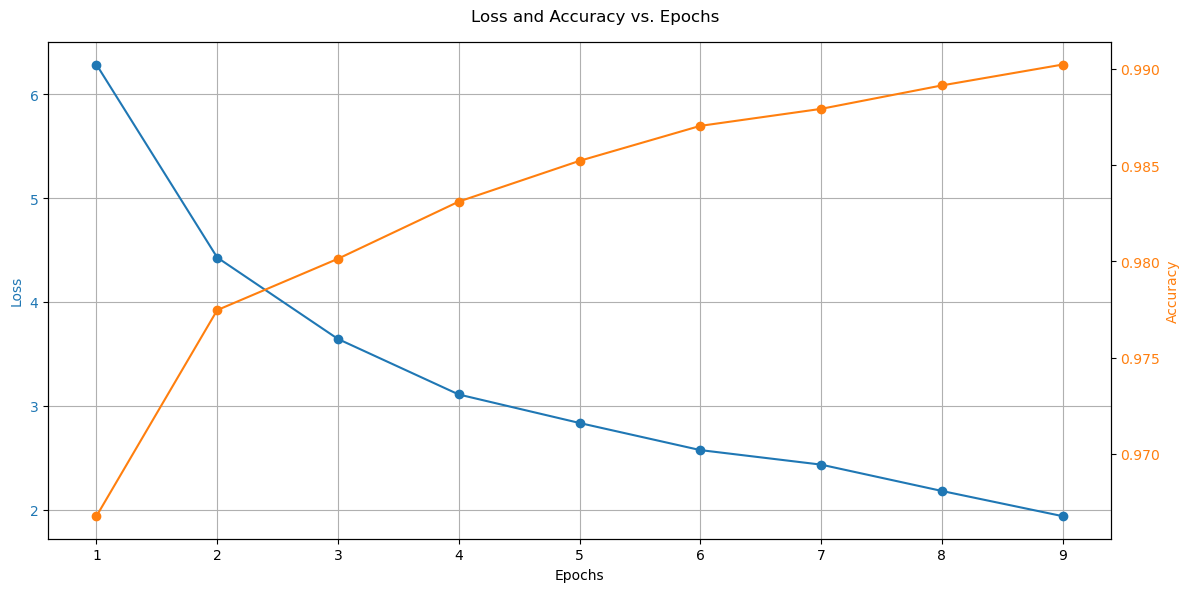

In [59]:
import matplotlib.pyplot as plt
min_length = min(len(loss_values), len(accuracies))
loss_values = loss_values[:min_length]
accuracies = accuracies[:min_length]


fig, ax1 = plt.subplots(figsize=(12, 6))

# Axe pour la perte (Loss)
color = 'tab:blue'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color=color)
ax1.plot(range(1, len(loss_values) + 1), loss_values, label="Loss", marker='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

# Ajouter un deuxième axe pour la précision (Accuracy)
ax2 = ax1.twinx()  # Instancier un second axe qui partage le même axe x
color = 'tab:orange'
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(range(1, len(accuracies) + 1), accuracies, label="Accuracy", marker='o', color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Titre et légende
fig.suptitle("Loss and Accuracy vs. Epochs")
fig.tight_layout()  # Ajuste automatiquement les espaces pour éviter les chevauchements
plt.show()


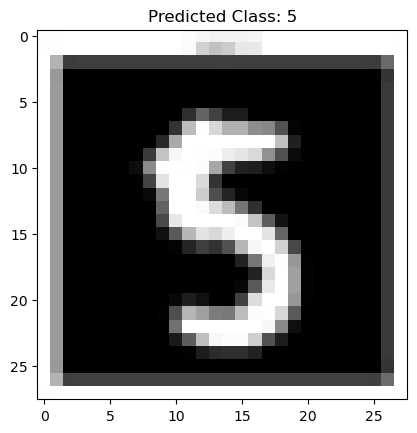

Predicted Class: 5


In [36]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Charger l'image à partir du fichier
image_path = 'OIF.jpg'
image = Image.open(image_path)

# Redimensionner l'image à 28x28 (en fonction de votre modèle)
image = image.resize((28, 28))

# Convertir l'image en niveaux de gris (si ce n'est pas déjà fait)
image = image.convert('L')

# Convertir l'image en un tableau numpy
image_array = np.array(image)

# Normaliser l'image entre 0 et 1 (si votre modèle a été entraîné sur des images normalisées)
image_array = image_array.astype('float32') / 255.0

# Ajouter une dimension pour la batch (le modèle attend une forme de [batch_size, 28, 28, 1])
image_array = np.expand_dims(image_array, axis=-1)

# Ajouter une autre dimension pour le batch (le modèle attend une entrée de forme [1, 28, 28, 1])
image_array = np.expand_dims(image_array, axis=0)

# Passer l'image à travers le modèle pour obtenir la prédiction
prediction = y_CNN(image_array)  # ou utilisez votre propre modèle ici

# Prédire la classe (si votre sortie est une probabilité)
predicted_class = np.argmax(prediction.numpy(), axis=1)

# Afficher l'image et la prédiction
plt.imshow(image, cmap='gray')
plt.title(f"Predicted Class: {predicted_class[0]}")
plt.show()

print(f"Predicted Class: {predicted_class[0]}")


## prediction

Classe prédite: 0, Confiance: 23.18%


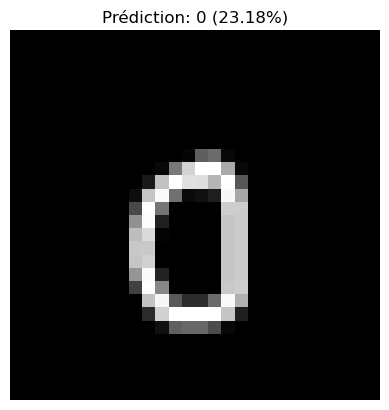

Classe prédite: 5, Confiance: 15.35%


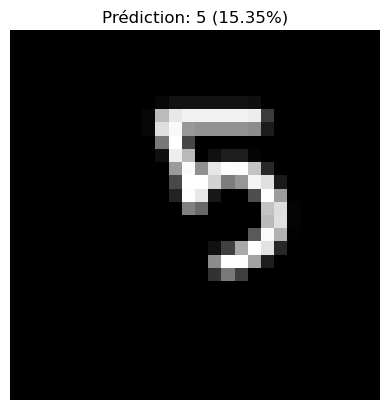

Classe prédite: 4, Confiance: 19.84%


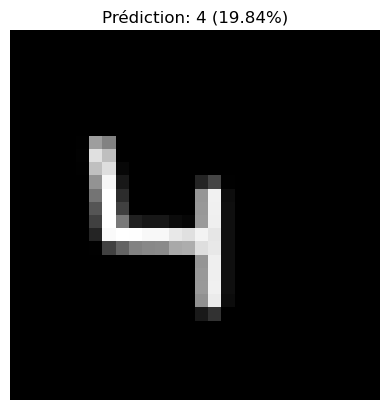

Classe prédite: 8, Confiance: 22.99%


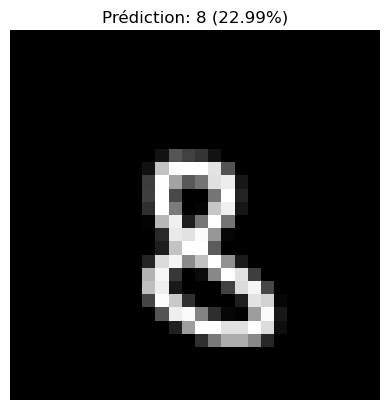

Classe prédite: 9, Confiance: 20.99%


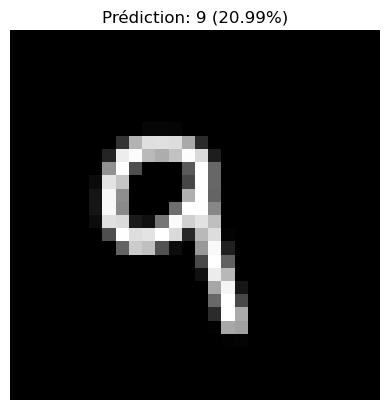

Classe prédite: 1, Confiance: 14.51%


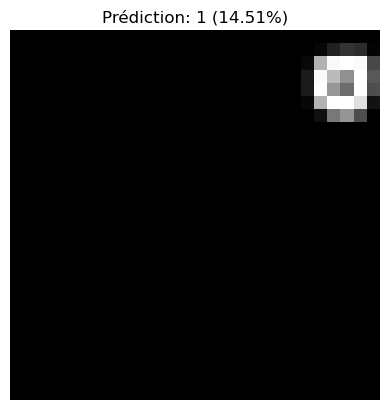

Classe prédite: 5, Confiance: 21.67%


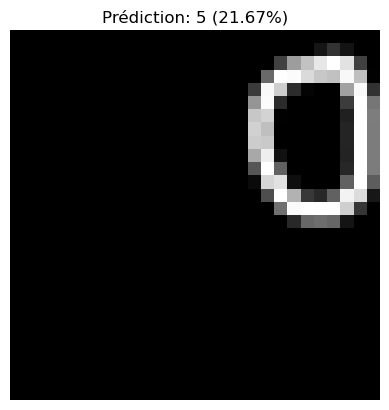

Classe prédite: 1, Confiance: 23.15%


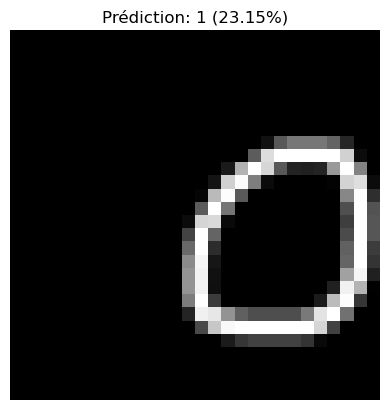

Classe prédite: 0, Confiance: 23.19%


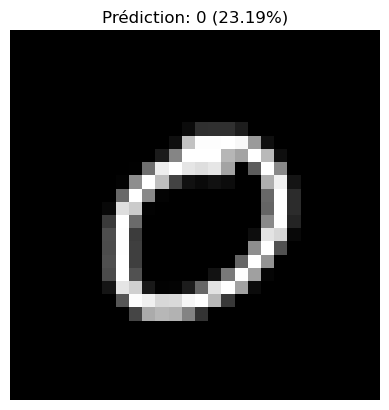

In [54]:

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import tkinter as tk

# Dimensions pour le canevas et les images
CANVAS_WIDTH = 200
CANVAS_HEIGHT = 200
IMG_SIZE = 28  # Taille cible pour le modèle (28x28)

# Création d'une image PIL pour stocker le dessin
image = Image.new("L", (CANVAS_WIDTH, CANVAS_HEIGHT), "black")
draw = ImageDraw.Draw(image)

# Initialisation de la fenêtre tkinter
root = tk.Tk()
root.title("Dessinez un chiffre")

# Fonction pour dessiner sur le canevas
def paint(event):
    x1, y1 = (event.x - 5), (event.y - 5)
    x2, y2 = (event.x + 5), (event.y + 5)
    canvas.create_oval(x1, y1, x2, y2, fill="white", outline="white")
    draw.ellipse([x1, y1, x2, y2], fill="white")

# Fonction pour effacer le canevas
def clear_canvas():
    canvas.delete("all")
    draw.rectangle([0, 0, CANVAS_WIDTH, CANVAS_HEIGHT], fill="black")

# Fonction pour prédire en temps réel
def predict_image():
    # Redimensionner l'image en 28x28
    img = image.resize((IMG_SIZE, IMG_SIZE))
    img_array = np.array(img) / 255.0  # Normalisation entre 0 et 1
    img_array = np.expand_dims(img_array, axis=(0, -1))  # Ajouter les dimensions batch et canal

    # Effectuer une prédiction
    prediction = y_CNN(img_array)  # Utiliser directement le modèle pour prédire
    predicted_class = np.argmax(prediction, axis=1)[0]  # Trouver la classe prédite
    confidence = np.max(tf.nn.softmax(prediction)) * 100  # Calculer la confiance

    # Afficher les résultats dans le terminal et la fenêtre matplotlib
    print(f"Classe prédite: {predicted_class}, Confiance: {confidence:.2f}%")

    plt.imshow(img_array.squeeze(), cmap="gray")
    plt.title(f"Prédiction: {predicted_class} ({confidence:.2f}%)")
    plt.axis("off")
    plt.show()

# Création du canevas tkinter
canvas = tk.Canvas(root, width=CANVAS_WIDTH, height=CANVAS_HEIGHT, bg="black")
canvas.pack()

# Lier les événements tkinter
canvas.bind("<B1-Motion>", paint)

# Boutons tkinter pour effacer et prédire
btn_clear = tk.Button(root, text="Effacer", command=clear_canvas)
btn_clear.pack(side=tk.LEFT, padx=10)

btn_predict = tk.Button(root, text="Prédire", command=predict_image)
btn_predict.pack(side=tk.RIGHT, padx=10)

# Lancer la fenêtre tkinter
root.mainloop()
